In [1]:
import os
import numpy as np
import pandas as pd
import pyarrow as pa
from astropy.time import Time

from mpcq.client import MPCObservationsClient
from mpcq.utils import observations_to_dataframe

client = MPCObservationsClient.connect_using_gcloud()

In [2]:
import ray

max_processes = 10
if not ray.is_initialized():
    ray.init(num_cpus=max_processes)

2024-02-29 07:40:02,307	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-02-29 07:40:05,183	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


This notebook requires `find_orb` to be installed. `find_orb` is a C/C++ code written by Bill Gray, that calculates an orbit given observations. Its a community favorite and in use by surveys like the Catalina Sky Survey. By default, find_orb will install its executables inside of ~/bin. 

See this [Dockerfile](https://github.com/Bill-Gray/find_orb/blob/master/Dockerfile) for instructions on how to install find_orb. 

In [3]:
from dataclasses import asdict
from typing import List
from mpcq.submission import Submission

def submissions_to_dataframe(submissions: List[Submission], observations_df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert a list of Submission objects to a pandas DataFrame.

    Parameters
    ----------
    submissions : List[Submission]
        The submissions to convert.

    Returns
    -------
    submissions : `~pd.DataFrame`
    """
    data = [asdict(sub) for sub in submissions]

    # Convert Time objects to datetime objects.
    for row in data:
        if row["timestamp"] is not None:

            row["timestamp"] = row["timestamp"].datetime
        else:
            print(f"Submission {row['id']} is missing a timestamp.")
            observations_submission = observations_df[observations_df["submission_id"] == row["id"]]
            observation_timestamp = observations_submission["timestamp"].max()
            row["timestamp"] = observation_timestamp
            print(f"Found {len(observations_submission)} observations for the submission and using the last timestamp [{observation_timestamp}].")

    return pd.DataFrame(data)

In [4]:
object_id = "2004 MN4"

# Query for this object's observations and its submission history
# We will use the submission history to determine the order in which
# observations for this object were found and submitted to the MPC

out_dir = os.path.join("mpc_data", object_id)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

observations_file = os.path.join(out_dir, "observations.parquet")
submissions_file = os.path.join(out_dir, "submissions.parquet")

if not os.path.exists(observations_file):
    observations = client.get_object_observations(object_id)
    observations = observations_to_dataframe(list(observations))
    observations.sort_values(by="timestamp", inplace=True, ignore_index=True)
    observations.to_parquet(observations_file)
else:
    observations = pd.read_parquet(observations_file)

if not os.path.exists(submissions_file):
    submissions = client.get_object_submissions(object_id)
    submissions = submissions_to_dataframe(list(submissions), observations)
    submissions.sort_values(by="timestamp", inplace=True, ignore_index=True)
    submissions.to_parquet(submissions_file)
            
else:
    submissions = pd.read_parquet(submissions_file)

In [5]:
observations

,mpc_id,status,obscode,filter_band,unpacked_provisional_designation,timestamp,ra,ra_rms,dec,dec_rms,mag,mag_rms,submission_id,created_at,updated_at
0,82718577,Published,691,None,2004 MN4,2004-03-15 02:35:22,61.533670,None,16.917940,None,None,None,2005-02-08T19:10:46.000_0000DaKP,2017-07-10,2022-04-08 14:05:39.235893
1,82718578,Published,691,None,2004 MN4,2004-03-15 02:38:58,61.535750,None,16.918360,None,None,None,2005-02-08T19:10:46.000_0000DaKP,2017-07-10,2022-04-08 14:05:39.240346
2,82718579,Published,691,None,2004 MN4,2004-03-15 02:58:03,61.548960,None,16.920970,None,None,None,2005-02-08T19:10:46.000_0000DaKP,2017-07-10,2022-04-08 14:05:39.243217
3,82718580,Published,691,None,2004 MN4,2004-03-15 03:01:51,61.551670,None,16.921580,None,None,None,2005-02-08T19:10:46.000_0000DaKP,2017-07-10,2022-04-08 14:05:39.244973
4,82718581,Published,691,None,2004 MN4,2004-03-15 03:17:37,61.562080,None,16.923720,None,None,None,2005-02-08T19:10:46.000_0000DaKP,2017-07-10,2022-04-08 14:05:39.246582
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,82719524,Published,941,V,2004 MN4,2005-06-16 20:57:22,150.564620,None,16.091080,None,20.5,None,2005-06-16T23:30:57.000_00004fCG,2017-07-10,2022-04-08 14:05:40.523505
938,82719525,Published,G96,None,2004 MN4,2005-06-17 03:50:31,150.709920,None,16.077280,None,None,None,2005-06-17T11:50:15.000_00004fGs,2017-07-10,2022-04-08 14:05:40.524480
939,82719526,Published,G96,None,2004 MN4,2005-06-17 03:56:19,150.712000,None,16.077000,None,None,None,2005-06-17T11:50:15.000_00004fGs,2017-07-10,2022-04-08 14:05:40.527241
940,82719527,Published,G96,None,2004 MN4,2005-06-17 04:02:07,150.714000,None,16.076750,None,None,None,2005-06-17T11:50:15.000_00004fGs,2017-07-10,2022-04-08 14:05:40.528561


In [6]:
import subprocess
import os
import tempfile
import json
import shutil
import uuid
import quivr as qv

from adam_core.orbits import Orbits
from adam_core.coordinates import CartesianCoordinates, CoordinateCovariances, Origin
from adam_core.time import Timestamp


class FittedOrbits(qv.Table):
    orbit_id = qv.LargeStringColumn(default= lambda: str(uuid.uuid4()))
    object_id = qv.LargeStringColumn()
    coordinates = CartesianCoordinates.as_column()
    included_observations = qv.Int64Column()
    rejected_observations = qv.Int64Column()
    arc_length = qv.Float64Column()

    def to_orbits(self) -> Orbits:
        return Orbits.from_kwargs(
            orbit_id=self.orbit_id,
            object_id=self.object_id,
            coordinates=self.coordinates,
        )

def observations_to_ades(observations, file_out) -> str:
    """
    Writes observations to a reduced MPC ADES file that can be 
    used with find_orb. 

    """
    ades = observations.rename(columns={
        "unpacked_provisional_designation": "provID",
        "timestamp": "obsTime",
        "ra_rms": "rmsRA",
        "dec_rms": "rmsDec",
        "mag_rms": "rmsMag",
        "filter_band": "band",
        "obscode": "stn",
    })

    column_order = ["provID", "obsTime", "ra", "dec", "mag", "rmsRA", "rmsDec", "rmsMag", "band", "stn"]
    ades = ades[column_order]

    observation_times = Time(
        ades["obsTime"].values,
        format="datetime64",
        scale="utc",
        precision=3,
    )
    ades["obsTime"] = np.array([i + "Z" for i in observation_times.utc.isot])

    # Note not necessarily true for all observations 
    ades["astCat"] = np.full(len(ades), "Gaia2")
    ades["mode"] = np.full(len(ades), "CCD")

    col_header = "|".join(ades.columns) + "\n"

    with open(file_out, "w") as f:
        f.write("# version=2017\n")
        f.write(col_header)

    return ades.to_csv(file_out, index=False, header=False, sep="|", mode="a")

def run_find_orb(observations, out_dir=None):
    """
    Runs find_orb on the given observations and returns the calculated
    orbit and covariance matrix. 

    """
    assert observations["unpacked_provisional_designation"].nunique() == 1

    my_env = os.environ.copy()
    my_env["PATH"] = f"{os.path.expanduser('~/bin')}:{my_env['PATH']}"

    with tempfile.TemporaryDirectory() as tempdir:
        ades_file = os.path.join(tempdir, "ades.psv")
        observations_to_ades(observations, ades_file)

        output = subprocess.run(
            ["fo", ades_file, "-O", tempdir, f"-tEjd{Time(observations['timestamp'].max(), scale='utc').utc.jd}", "-j"],
            capture_output=True,
            text=True,
            env=my_env,
        )

        if output.returncode != 0:
            raise RuntimeError(f"find_orb failed: {output.stderr}")
        
        # Read orbit and covariance from covar.json
        try:
            with open(os.path.join(tempdir, "covar.json")) as f:
                result = json.load(f)
                
                state = np.array(result["state_vect"])
                covariance_matrix = np.array(result["covar"]).reshape(1, 6, 6)
                coords = CartesianCoordinates.from_kwargs(
                    time=Timestamp.from_jd([result["epoch"]], scale="tt"),
                    x=state[0:1],
                    y=state[1:2],
                    z=state[2:3],
                    vx=state[3:4],
                    vy=state[4:5],
                    vz=state[5:],
                    covariance=CoordinateCovariances.from_matrix(covariance_matrix),
                    origin=Origin.from_kwargs(code=["SUN"]),
                    frame="ecliptic",
                )
        
        except FileNotFoundError:
            return FittedOrbits.empty()

        # Read information about the observations used from total.json
        with open(os.path.join(tempdir, "total.json")) as f:
            result_total = json.load(f)

            object_id = observations["unpacked_provisional_designation"].values[0]
            included_observations = result_total["objects"][object_id]["observations"]["used"]
            rejected_observations = result_total["objects"][object_id]["observations"]["count"] - included_observations
            arc_length = result_total["objects"][object_id]["observations"]["latest_used"] - result_total["objects"][object_id]["observations"]["earliest_used"]

        if out_dir is not None:
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            shutil.copytree(tempdir, out_dir)
            shutil.copy(ades_file, out_dir)
        
    return FittedOrbits.from_kwargs(
        object_id=observations["unpacked_provisional_designation"].values[:1], 
        coordinates=coords,
        included_observations=[included_observations],
        rejected_observations=[rejected_observations],
        arc_length=[arc_length],
    )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [7]:
orbit_fits_dir = os.path.join("orbit_fits", object_id)
if not os.path.exists(orbit_fits_dir):
    os.makedirs(orbit_fits_dir)

def run_object_observations_by_submission(observations, submissions=None):
    """
    Runs find_orb on the observations for a given object, grouped by
    submission. 

    """
    fitted_orbits = []
    submission_ids = []
    last_submission = []

    if submissions is None:
        unique_submission_ids = observations["submission_id"].unique()
    else:
        unique_submission_ids = submissions["id"].unique()

    for i, submission_id in enumerate(unique_submission_ids):
        submission_ids.append(submission_id)
        observations_subset = observations[observations["submission_id"].isin(submission_ids)]

        if len(observations_subset) < 6:
            print(f"Skipping submissions up to {submission_id} with fewer than 6 total observations.")
            continue

        fitted_orbits_i = run_find_orb(observations_subset)
        if len(fitted_orbits_i) > 0:
            fitted_orbits_i = fitted_orbits_i.set_column("orbit_id", pa.array([f"{i:03d}::{submission_id}"], type=pa.large_string()))

            fitted_orbits.append(fitted_orbits_i)
            last_submission.append(submission_id)
        else:
            print(f"Orbit fit for submissions up to {submission_id} failed.")

    return last_submission, qv.concatenate(fitted_orbits)

orbit_file = os.path.join(orbit_fits_dir, "orbits.parquet")
submission_ids_file = os.path.join(orbit_fits_dir, "submission_ids.txt")

if not os.path.exists(orbit_file):
    last_submission, orbits = run_object_observations_by_submission(observations, submissions)
    orbits.to_parquet(orbit_file)
    np.savetxt(submission_ids_file, last_submission, fmt="%s")

else:
    orbits = FittedOrbits.from_parquet(orbit_file)
    last_submission = np.loadtxt(submission_ids_file, dtype=str)

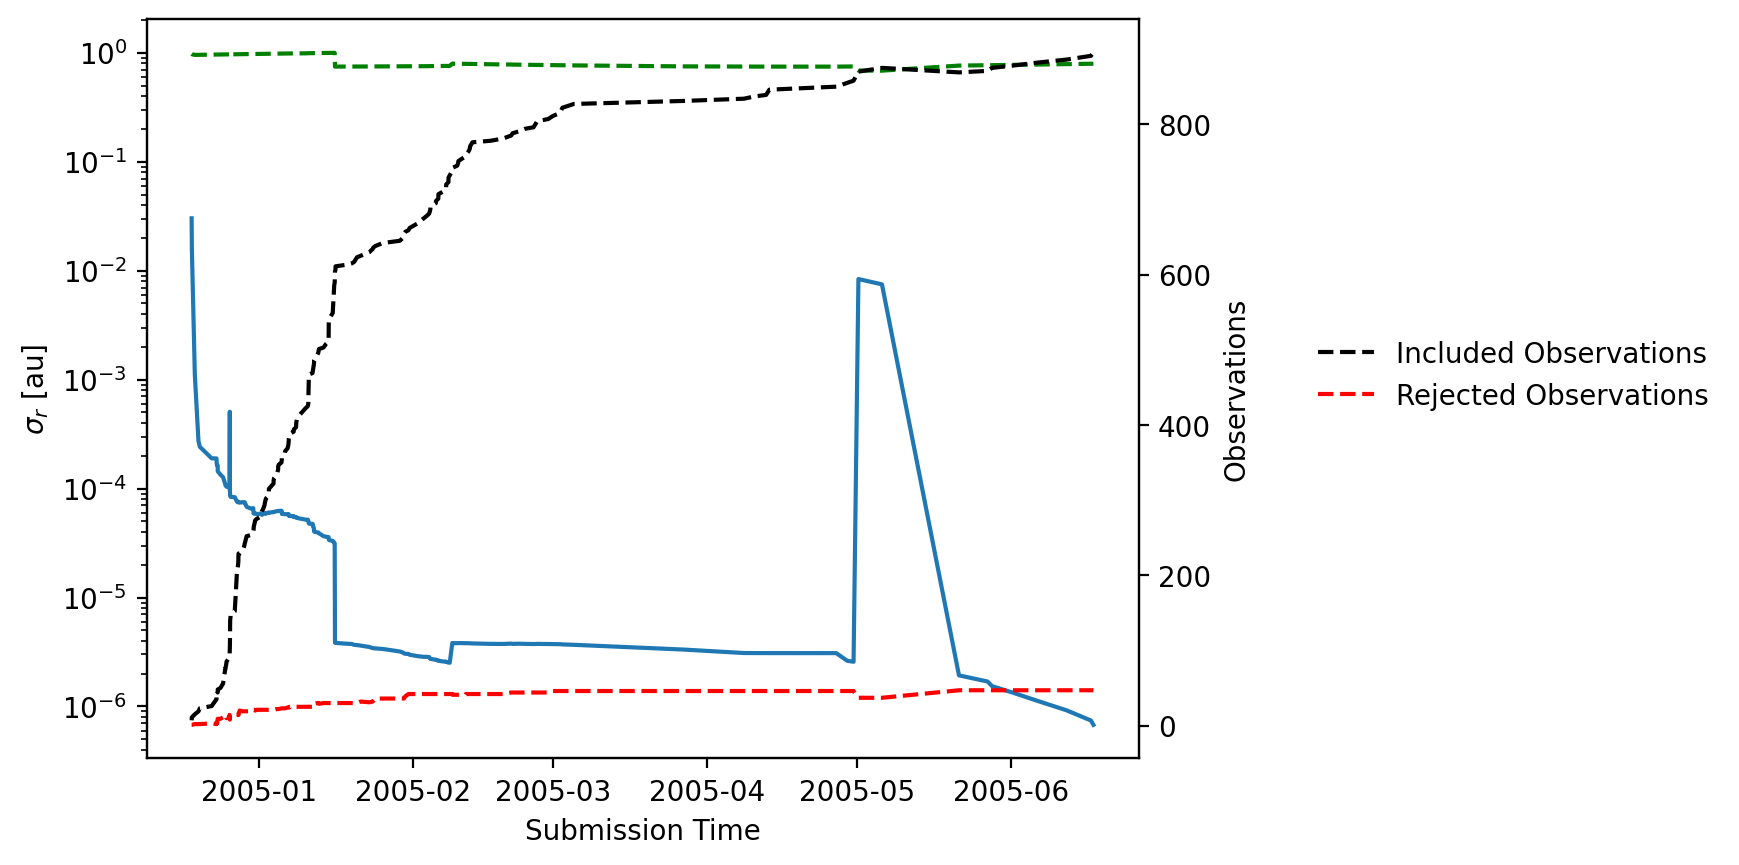

In [8]:
import matplotlib.pyplot as plt

if submissions is None:
    timestamps = observations.groupby(["submission_id"])["timestamp"].max().values
    timestamps.sort()
else:
    timestamps = submissions[submissions["id"].isin(last_submission)]["timestamp"]

fig, ax = plt.subplots(1, 1, dpi=200)
ax.plot(timestamps, orbits.coordinates.sigma_r_mag)
ax.plot(timestamps, orbits.coordinates.r_mag, c="green", ls="--")
ax.set_yscale("log")
ax.set_ylabel(r"$\sigma_r$ [au]")
ax.set_xlabel("Submission Time")

ax2 = ax.twinx()
ax2.plot(
    timestamps, 
    orbits.included_observations, 
    c="k", 
    ls="--",
    label="Included Observations"
)
ax2.plot(
    timestamps, 
    orbits.rejected_observations, 
    c="r", 
    ls="--",
    label="Rejected Observations"
)
ax2.set_ylabel("Observations")
ax2.legend(frameon=False, bbox_to_anchor=(1.6, 0.6))

In [9]:
from astropy.time import Time

from adam_core.orbits import VariantOrbits
from adam_core.propagator import PYOORB

propagator = PYOORB()

submission_ids = submissions["id"].values
submission_times = Time(submissions["timestamp"].values, scale="utc", format="datetime64")
num_samples = 1000
num_steps = 5

orbits_at_submission = None
propagated_variants = None
gap_percent = 5

for i, orbit in enumerate(orbits):

    # Get submission ID from this orbit's ID
    orbit_id = orbit.orbit_id[0].as_py()
    submission_number, submission_id = orbit_id.split("::")
    submission_number = int(submission_number)

    # Get the time of this submission and the next 
    submission_time = submission_times[submission_number]
    # If its not the last submission, use the time of the next submission
    if i < len(orbits) - 1:
        next_submission_time = submission_times[submission_number + 1]

    # If this is the last submission then use a custom end time
    else:
        if object_id == "2000 SG344":
            next_submission_time = Time("2075-01-01T00:00:00.000", format="isot")
        else:
            next_submission_time = Time("2024-01-01T00:00:00.000", format="isot")

    # If the next submission time is less than a day away, then only use a single time step
    if (next_submission_time - submission_time).jd < 1:
        num_steps = 2
    
    # Create a set of propagation times between the time of this submission and the next
    time_steps = np.linspace(submission_time.utc.mjd, next_submission_time.utc.mjd, num_steps, endpoint=True)
    time_steps[0] = gap_percent * (time_steps[1] - time_steps[0]) / 100 + time_steps[0]
    time_steps[-1] = time_steps[-1] - gap_percent * (time_steps[-1] - time_steps[-2]) / 100
    propagation_times = Timestamp.from_mjd(time_steps, scale="utc")

    # Propagate the best-fit orbit to time of current submission (it might be defined at a different time, typically
    # at the time of the one of the observations within the submission)
    orbit_at_submission_i = propagator.propagate_orbits(
        orbit.to_orbits(), 
        propagation_times, 
        covariance=True,
        covariance_method="monte-carlo",
        num_samples=num_samples, 
        parallel_backend="ray",
        max_processes=max_processes
    )
    if orbits_at_submission is None:
        orbits_at_submission = orbit_at_submission_i
    else:
        orbits_at_submission = qv.concatenate([orbits_at_submission, orbit_at_submission_i])
        if orbits_at_submission.fragmented():
            orbits_at_submission = qv.defragment(orbits_at_submission)

    # Create variants for this propagated best-orbit
    variants = VariantOrbits.create(
        orbit_at_submission_i[0], 
        method="monte-carlo", 
        num_samples=num_samples
    )
    assert len(variants) == num_samples
    variants = variants.set_column(
        "orbit_id", 
        pa.array([f"{submission_number:03d}::{submission_id}::{i + 1:06}" for i in range(len(variants))], type=pa.large_string())
    )

    # Propagate the variants to the time of the next submission
    propagated_variants_i = propagator.propagate_orbits(
        Orbits.from_kwargs(
            orbit_id=variants.orbit_id,
            object_id=variants.object_id,
            coordinates=variants.coordinates,
        ), 
        propagation_times,
        covariance=False,
        parallel_backend="ray",
        chunk_size=num_samples//max_processes,
        max_processes=max_processes
    )    
    if propagated_variants is None:
        propagated_variants = propagated_variants_i
    else:
        propagated_variants = qv.concatenate([propagated_variants, propagated_variants_i])
        if propagated_variants.fragmented():
            propagated_variants = qv.defragment(propagated_variants)

# Convert propagated variants to UTC
orbits_at_submission = orbits_at_submission.set_column("coordinates.time", orbits_at_submission.coordinates.time.rescale("utc"))
propagated_variants = propagated_variants.set_column("coordinates.time", propagated_variants.coordinates.time.rescale("utc"))

2024-02-29 07:40:08,048	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
(pid=3012415) An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [10]:
propagated_variants_df = propagated_variants.to_dataframe()
propagated_variants_df["mjd"] = propagated_variants.coordinates.time.mjd()

In [11]:
propagated_variants_df

,orbit_id,object_id,coordinates.x,coordinates.y,coordinates.z,coordinates.vx,coordinates.vy,coordinates.vz,coordinates.time.days,coordinates.time.nanos,coordinates.covariance.values,coordinates.origin.code,mjd
0,001::2004-12-18T11:08:30.001_00005EFu::000001,2004 MN4,0.075810,0.971958,-0.013041,-0.014433,0.000984,-0.002015,53357,40308800950151,None,SUN,53357.466537
1,001::2004-12-18T11:08:30.001_00005EFu::000001,2004 MN4,0.075210,0.971999,-0.013125,-0.014434,0.000971,-0.002015,53357,43897140047716,None,SUN,53357.508069
2,001::2004-12-18T11:08:30.001_00005EFu::000002,2004 MN4,0.060085,0.979721,-0.003405,-0.008487,-0.003162,-0.005621,53357,40308800950151,None,SUN,53357.466537
3,001::2004-12-18T11:08:30.001_00005EFu::000002,2004 MN4,0.059732,0.979589,-0.003638,-0.008488,-0.003175,-0.005621,53357,43897140047716,None,SUN,53357.508069
4,001::2004-12-18T11:08:30.001_00005EFu::000003,2004 MN4,0.076991,0.971373,-0.013764,-0.017051,0.002281,-0.000375,53357,40308800950151,None,SUN,53357.466537
...,...,...,...,...,...,...,...,...,...,...,...,...,...
367995,184::2005-06-17T11:50:15.000_00004fGs::000998,2004 MN4,-0.770473,-0.577508,0.012539,0.012654,-0.011529,0.000915,59988,30536212499764,None,SUN,59988.353428
367996,184::2005-06-17T11:50:15.000_00004fGs::000999,2004 MN4,-0.159822,-0.822249,0.039714,0.019608,-0.000409,0.000494,53877,5924250000500,None,SUN,53877.068568
367997,184::2005-06-17T11:50:15.000_00004fGs::000999,2004 MN4,-0.770471,-0.577510,0.012539,0.012654,-0.011529,0.000915,59988,30536212499764,None,SUN,59988.353428
367998,184::2005-06-17T11:50:15.000_00004fGs::001000,2004 MN4,-0.159822,-0.822248,0.039714,0.019608,-0.000409,0.000494,53877,5924250000500,None,SUN,53877.068568
